# Demo - LISA Horizon Distance
This demo shows how to use ``LEGWORK`` to compute the horizon distance for a collection of sources.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

import legwork
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [3]:
from importlib import reload
reload(legwork)

<module 'legwork' from '../../legwork/__init__.py'>

In [4]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## Formatting for labels

In [5]:
def fmt_time(x):
    if x == 4:
        return r"$t_{\rm merge} = T_{\rm obs}$"#"LISA Misson time"
    elif x >= 1e9:
        return "{0:1.0f} Gyr".format(x / 1e9)
    elif x >= 1e6:
        return "{0:1.0f} Myr".format(x / 1e6)
    elif x >= 1e3:
        return "{0:1.0f} kyr".format(x / 1e3)
    elif x >= 1:
        return "{0:1.0f} yr".format(x)
    elif x >= 1/12:
        return "{0:1.0f} month".format(x * 12)
    else:
        return "{0:1.0f} week".format(x * 52)
    
def fmt_dist(x):
    if x >= 1e9:
        return "{0:1.0f} Gpc".format(x / 1e9)
    elif x >= 1e6:
        return "{0:1.0f} Mpc".format(x / 1e6)
    elif x >= 1e3:
        return "{0:1.0f} kpc".format(x / 1e3)
    else:
        return "{0:1.0f} pc".format(x)
    
def fmt_name(x):
    if x == np.log10(8):
        return "MW Centre"
    elif x == np.log10(50):
        return "SMC/LMC"
    elif x == np.log10(800):
        return "Andromeda"
    elif x == np.log10(40000):
        return "GW170817"

## Horizon distance with chirp mass

In [55]:
# create a list of masses and frequencies
m_c_grid = np.logspace(-1, np.log10(50), 500) * u.Msun
f_orb_grid = np.logspace(np.log10(4e-5), np.log10(3e-1), 400) * u.Hz

# turn the two lists into grids
MC, FORB = np.meshgrid(m_c_grid, f_orb_grid)

# flatten grids
m_c, f_orb = MC.flatten(), FORB.flatten()

# convert chirp mass to individual masses for source class
q = 1.0
m_1 = m_c / q**(3/5) * (1 + q)**(1/5)
m_2 = m_1 * q

# use a fixed distance and circular binaries
dist = np.repeat(1, len(m_c)) * u.kpc
ecc = np.zeros(len(m_c))

# create the source class
sources = legwork.source.Source(m_1=m_1, m_2=m_2, dist=dist, f_orb=f_orb, ecc=ecc, gw_lum_tol=1e-3)

In [56]:
# calculate merger times and then SNR
sources.get_merger_time()
sources.get_snr(verbose=True)

Calculating SNR for 200000 sources
	125169 sources are stationary
		125169 sources are stationary and circular
	74831 sources are evolving
		74831 sources are evolving and circular


array([5.37039831e-04, 5.48303595e-04, 5.59803603e-04, ...,
       1.06420933e+04, 1.07531750e+04, 1.08654183e+04])

In [57]:
# reshape the output into grids
t_merge_grid = sources.t_merge.reshape(MC.shape)
snr_grid = sources.snr.reshape(MC.shape)

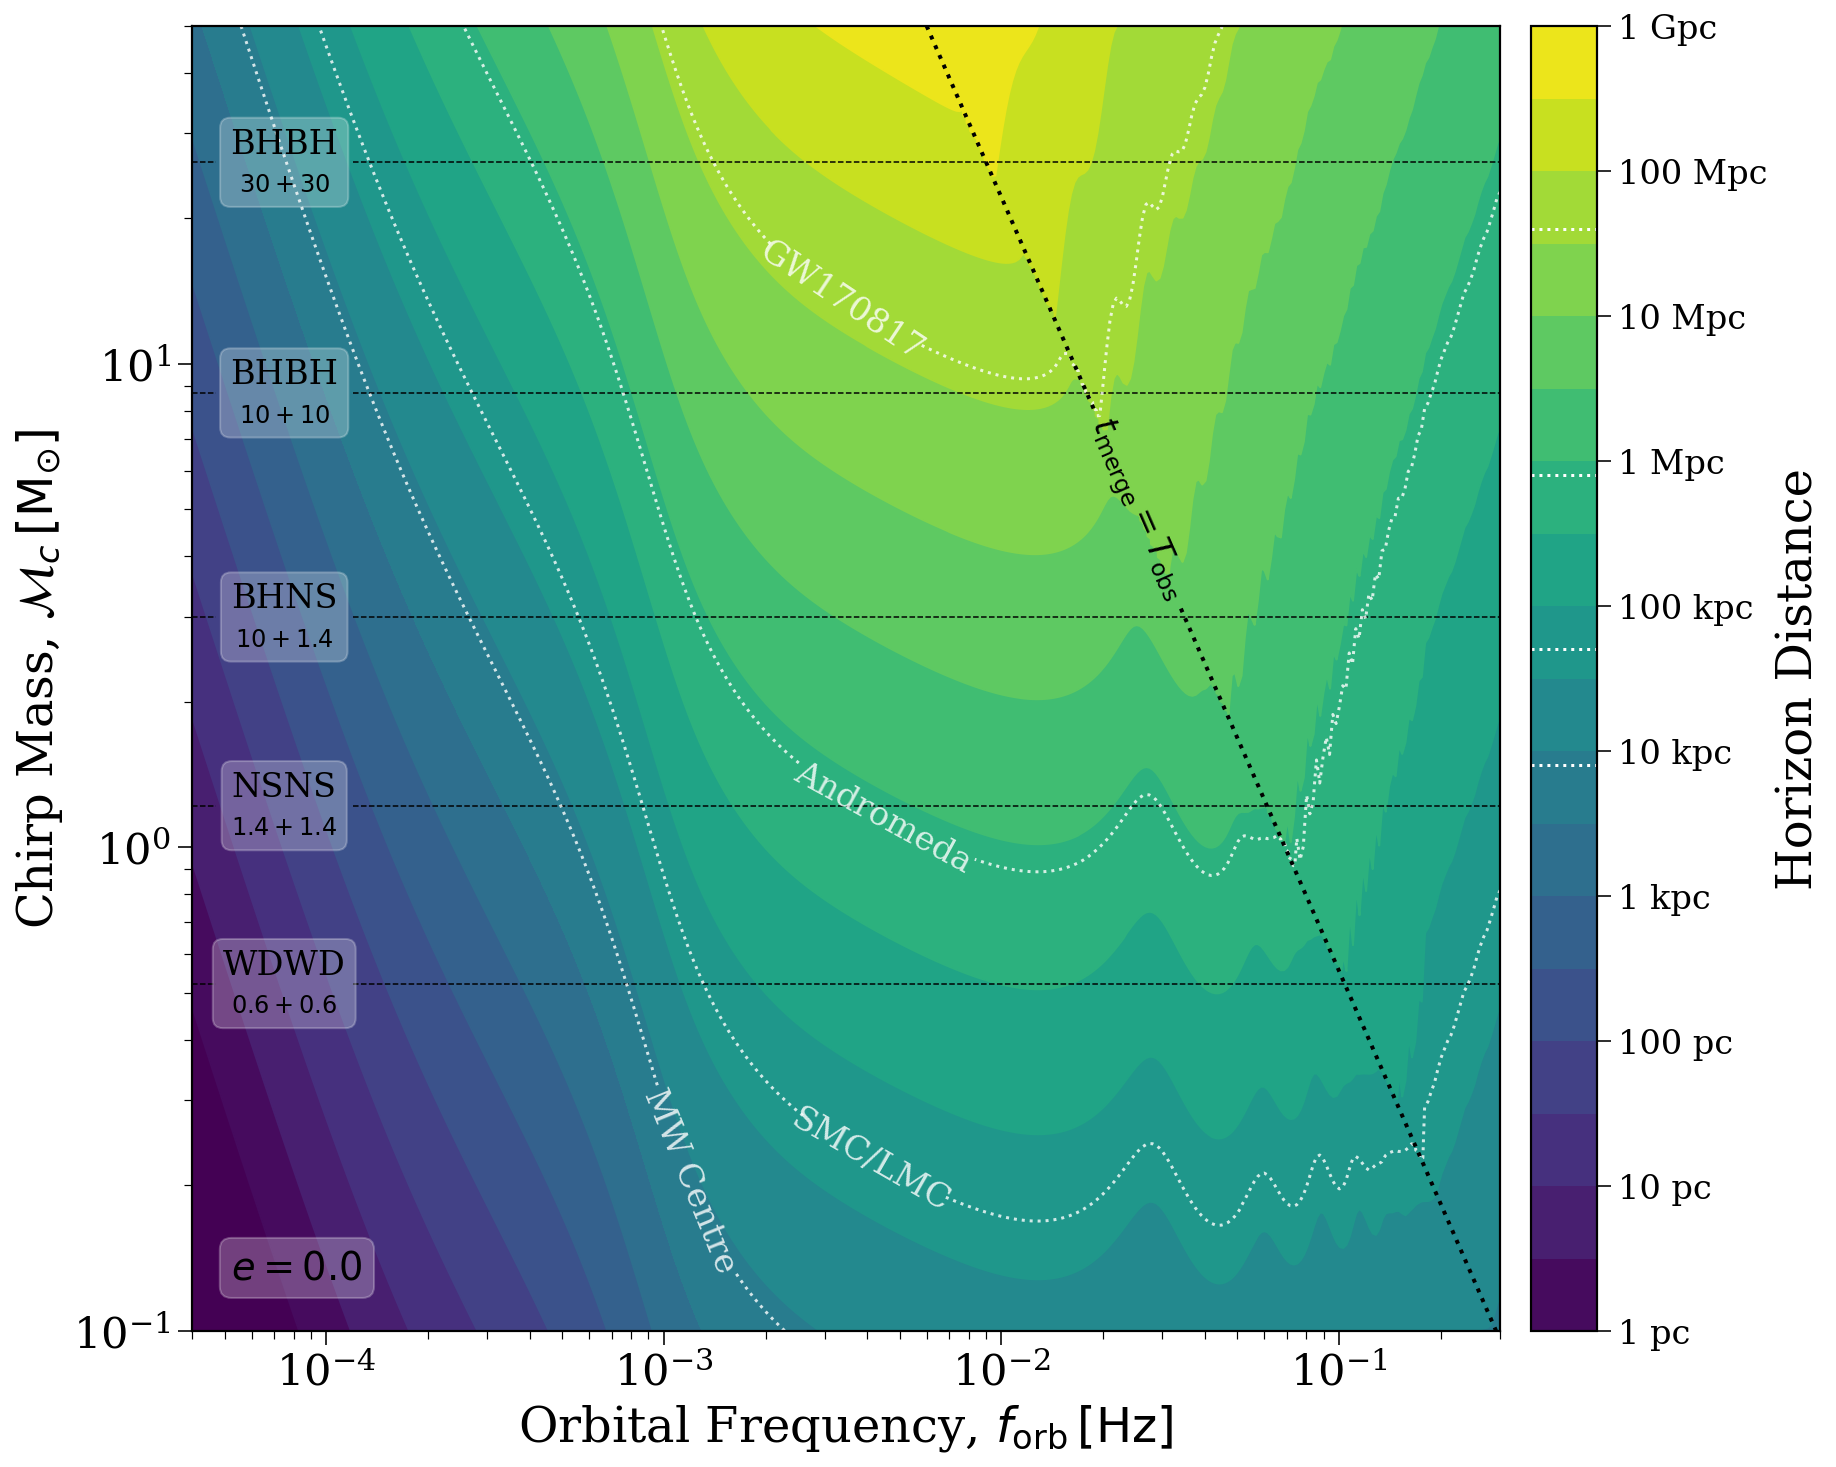

In [59]:
# create a square figure plus some space for a colourbar
size = 12
cbar_space = 2
fig, ax = plt.subplots(figsize=(size + cbar_space, size))

# set up scales early so contour labels show up nicely
ax.set_xscale("log")
ax.set_yscale("log")

# set axes labels and lims
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb} \, [\rm Hz]$")
ax.set_ylabel(r"Chirp Mass, $\mathcal{M}_c \, [\rm M_{\odot}]$")
ax.set_xlim(4e-5, 3e-1)

# calculate the horizon distance
snr_threshold = 7
horizon_distance = (snr_grid / snr_threshold * 1 * u.kpc).to(u.kpc)

# set up the contour levels
distance_levels = np.arange(-3, 6 + 0.5, 0.5)
distance_tick_levels = distance_levels[::2]

# plot the contours for horizon distance
distance_cont = ax.contourf(FORB, MC, np.log10(horizon_distance.value), levels=distance_levels)

# hide edges that show up in rendered PDFs
for c in distance_cont.collections:
    c.set_edgecolor("face")

# create a colour with custom formatted labels
cbar = fig.colorbar(distance_cont, ax=ax, pad=0.02, ticks=distance_tick_levels, fraction=cbar_space / (size + cbar_space))
cbar.ax.set_yticklabels([fmt_dist(np.power(10, distance_tick_levels + 3)[i]) for i in range(len(distance_tick_levels))])
cbar.set_label(r"Horizon Distance", fontsize=fs)
cbar.ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)

# annotate the colourbar with some named distances
named_distances = np.log10([8, 50, 800, 40000])
for name in named_distances:
    cbar.ax.axhline(name, color="white", linestyle="dotted")
    
# plot the same names as contours
named_cont = ax.contour(FORB, MC, np.log10(horizon_distance.value), levels=named_distances,
                        colors="white", alpha=0.8, linestyles="dotted")
ax.clabel(named_cont, named_cont.levels, fmt=fmt_name, use_clabeltext=True, fontsize=0.7*fs,
          manual=[(1.1e-3, 2e-1), (4e-3, 2.2e-1), (4e-3,1e0), (3e-3, 1.2e1)])

# add a line for when the merger time becomes less than the inspiral time
time_cont = ax.contour(FORB, MC, t_merge.to(u.yr).value, levels=[4],
                       colors="black", linewidths=2, linestyles="dotted") #[1/52, 1/12, 4, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
ax.clabel(time_cont, time_cont.levels, fmt=fmt_time, fontsize=0.7*fs, use_clabeltext=True, manual=[(2.5e-2, 5e0)])

# plot a series of lines and annotations for average DCO masses
for m_1, m_2, dco in [(0.6, 0.6, "WDWD"), (1.4, 1.4, "NSNS"),
                      (10, 1.4, "BHNS"), (10, 10, "BHBH"), (30, 30, "BHBH")]:
    # find chirp mass
    m_c_val = legwork.utils.chirp_mass(m_1, m_2)
    
    # plot lines before and after bbox
    ax.plot([4e-5, 4.7e-5], [m_c_val, m_c_val],
            color="black", lw=0.75, zorder=1, linestyle="--")
    ax.plot([1.2e-4, 1e0], [m_c_val, m_c_val],
            color="black", lw=0.75, zorder=1, linestyle="--")
    
    # plot name and bbox, then masses below in smaller font
    ax.annotate(dco + "\n", xy=(7.5e-5, m_c_val), ha="center", va="center", fontsize=0.7*fs,
               bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.25))
    ax.annotate(r"${{{}}} + {{{}}}$".format(m_1, m_2),
               xy=(7.5e-5, m_c_val * 0.95), ha="center", va="top", fontsize=0.5*fs)
    
# ensure that everyone knows this only applies for circular sources
ax.annotate(r"$e = 0.0$", xy=(0.03, 0.04), xycoords="axes fraction", fontsize=0.8*fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.25))

ax.set_facecolor(plt.get_cmap("viridis")(0.0))

plt.savefig("/Users/tomwagg/Documents/LW_paper/horizon_distance_chirp_mass.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Horizon distance with eccentricity

In [11]:
# create a list of masses and frequencies
ecc_grid = np.linspace(0, 0.99, 50)
f_orb_grid = np.logspace(np.log10(4e-5), np.log10(3e-1), 200) * u.Hz

# turn the two lists into grids
ECC, FORB = np.meshgrid(ecc_grid, f_orb_grid)

# flatten grids
ecc, f_orb = ECC.flatten(), FORB.flatten()

# use a fixed distance and mass
dist = np.repeat(1, len(ecc)) * u.kpc
m_1 = np.repeat(10, len(ecc)) * u.Msun
m_2 = np.repeat(10, len(ecc)) * u.Msun

# create the source class
sources = legwork.source.Source(m_1=m_1, m_2=m_2, dist=dist, f_orb=f_orb, ecc=ecc, gw_lum_tol=1e-3)

In [12]:
# calculate merger times and then SNR
sources.get_merger_time()
sources.get_snr(t_obs=4*u.yr, verbose=True)

Calculating SNR for 10000 sources
	4193 sources are stationary
		106 sources are stationary and circular
		4087 sources are stationary and eccentric
	5807 sources are evolving
		94 sources are evolving and circular
		5713 sources are evolving and eccentric


array([ 0.91832519,  0.92744332,  0.95481835, ..., 29.6849565 ,
       12.01619553,  1.69262564])

In [13]:
# reshape the output into grids
snr_grid = sources.snr.reshape(ECC.shape)
t_merge = sources.t_merge.reshape(ECC.shape)

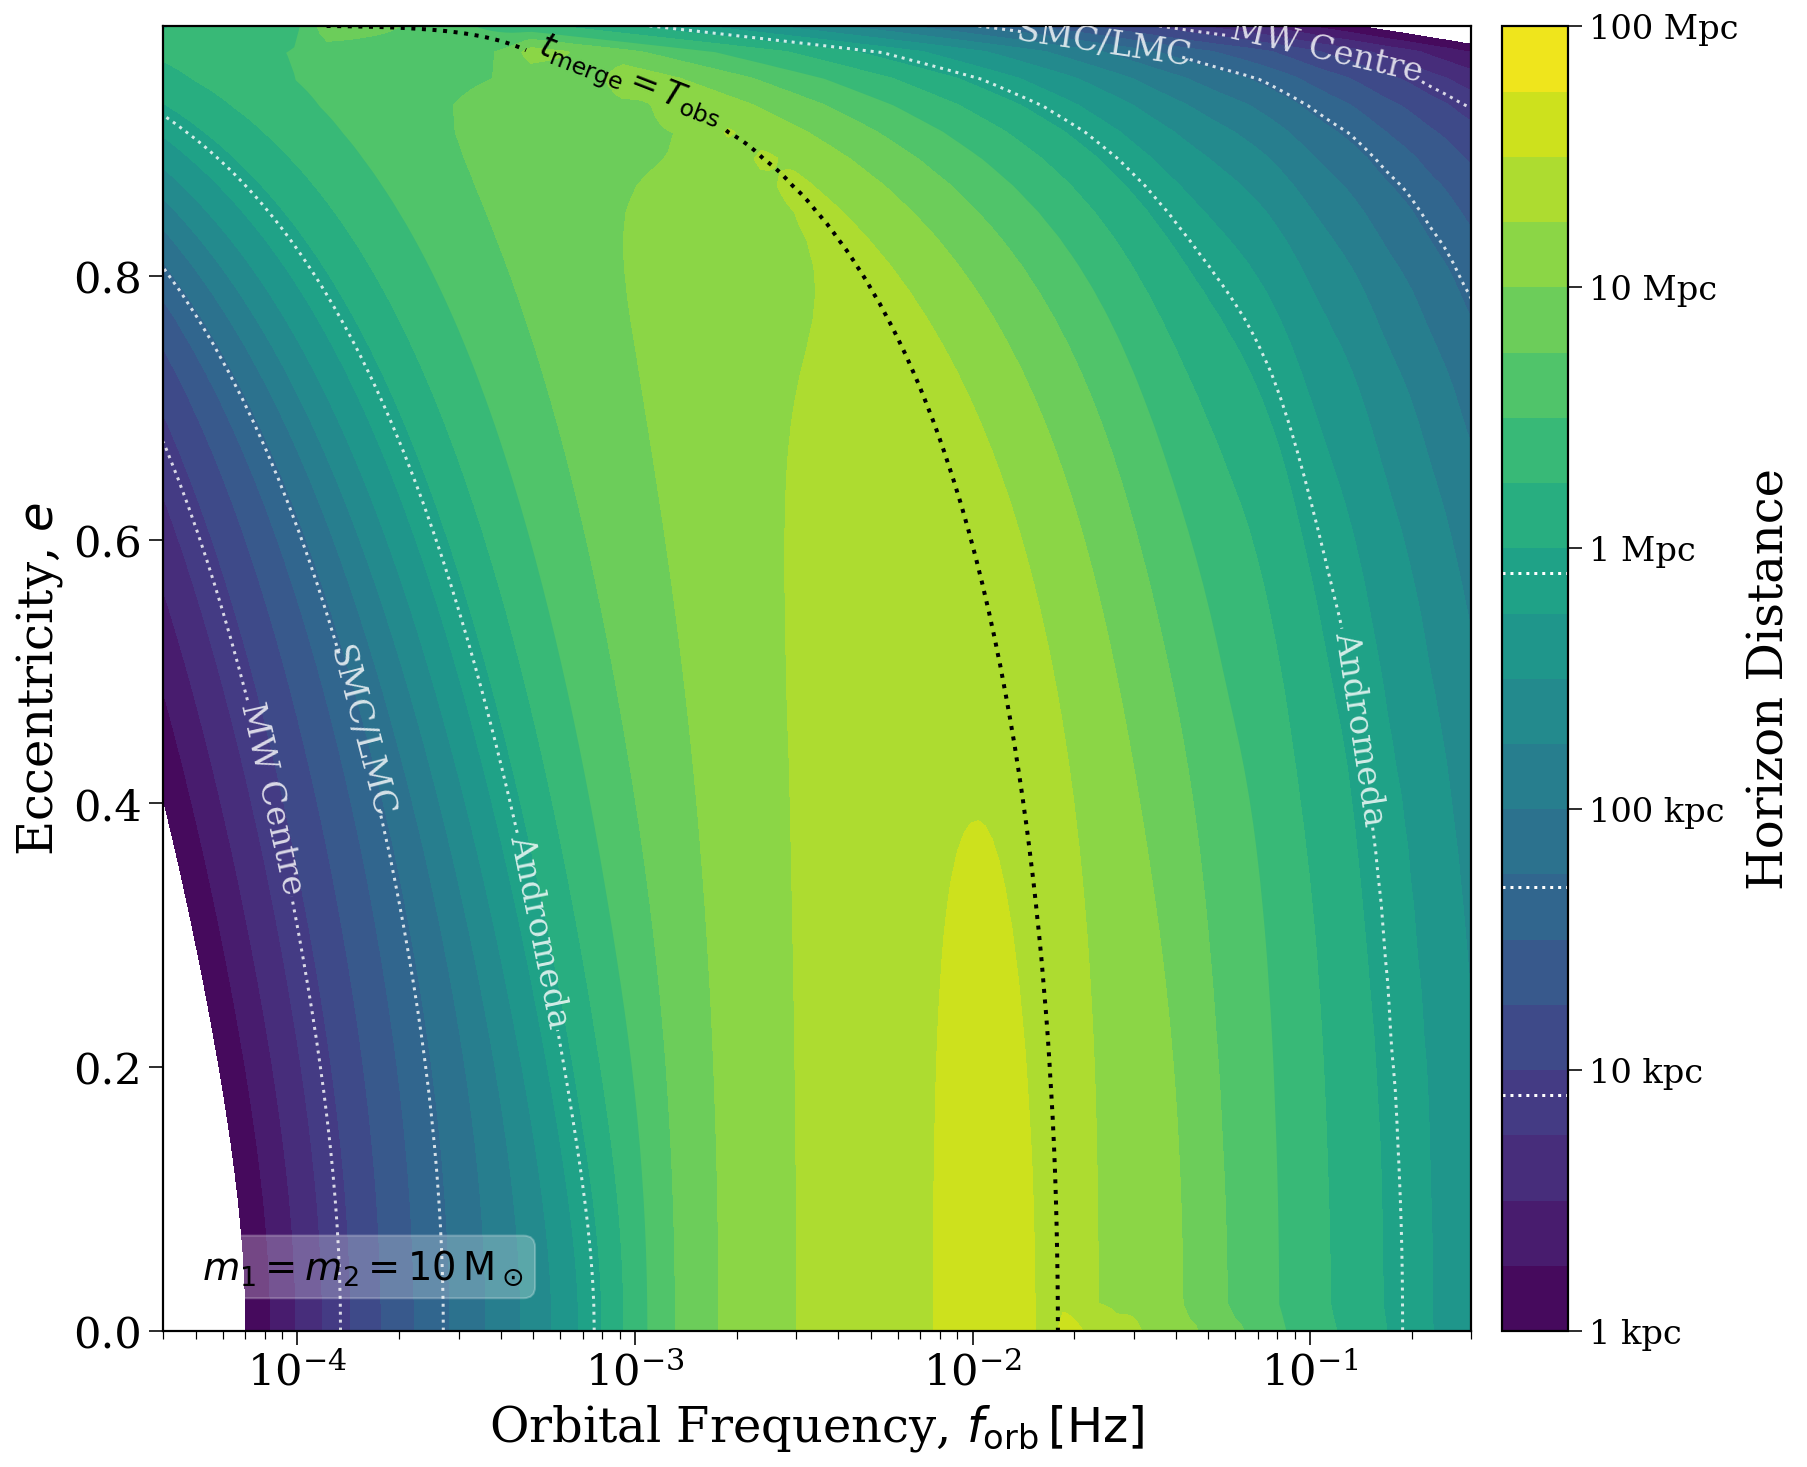

In [14]:
# create a square figure plus some space for a colourbar
size = 12
cbar_space = 2
fig, ax = plt.subplots(figsize=(size + cbar_space, size))

# set up scales early so contour labels show up nicely
ax.set_xscale("log")

# set axes labels and lims
ax.set_xlabel(r"Orbital Frequency, $f_{\rm orb} \, [\rm Hz]$")
ax.set_ylabel(r"Eccentricity, $e$")
ax.set_xlim(4e-5, 3e-1)

# calculate the horizon distance
snr_threshold = 7
horizon_distance = (snr_grid / snr_threshold * 1 * u.kpc).to(u.kpc)

# set up the contour levels
distance_levels = np.arange(0, 5 + 0.25, 0.25)
distance_tick_levels = distance_levels[::4]

# plot the contours for horizon distance
distance_cont = ax.contourf(FORB, ECC, np.log10(horizon_distance.value), levels=distance_levels)

# hide edges that show up in rendered PDFs
for c in distance_cont.collections:
    c.set_edgecolor("face")

# create a colour with custom formatted labels
cbar = fig.colorbar(distance_cont, ax=ax, pad=0.02, ticks=distance_tick_levels, fraction=cbar_space / (size + cbar_space))
cbar.ax.set_yticklabels([fmt_dist(np.power(10, distance_tick_levels + 3)[i]) for i in range(len(distance_tick_levels))])
cbar.set_label(r"Horizon Distance", fontsize=fs)
cbar.ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)

# annotate the colourbar with some named distances
named_distances = np.log10([8, 50, 800])
for name in named_distances:
    cbar.ax.axhline(name, color="white", linestyle="dotted")
    
# plot the same names as contours
named_cont = ax.contour(FORB, ECC, np.log10(horizon_distance.value), levels=named_distances,
                        colors="white", alpha=0.8, linestyles="dotted")
ax.clabel(named_cont, named_cont.levels, fmt=fmt_name, use_clabeltext=True, fontsize=0.7*fs)

# add a line for when the merger time becomes less than the inspiral time
time_cont = ax.contour(FORB, ECC, t_merge.to(u.yr).value, levels=[4],
                       colors="black", linewidths=2, linestyles="dotted") #[1/52, 1/12, 4, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
ax.clabel(time_cont, time_cont.levels, fmt=fmt_time, fontsize=0.7*fs, use_clabeltext=True)
    
# ensure that everyone knows this only applies for circular sources
ax.annotate(r"$m_1 = m_2 = 10 \, {\rm M_\odot}$", xy=(0.03, 0.04), xycoords="axes fraction", fontsize=0.8*fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.25))

# ax.set_facecolor(plt.get_cmap("viridis")(0.0))

# plt.savefig("/Users/tomwagg/Documents/LW_paper/horizon_distance_eccentricity.pdf", format="pdf", bbox_inches="tight")

plt.show()

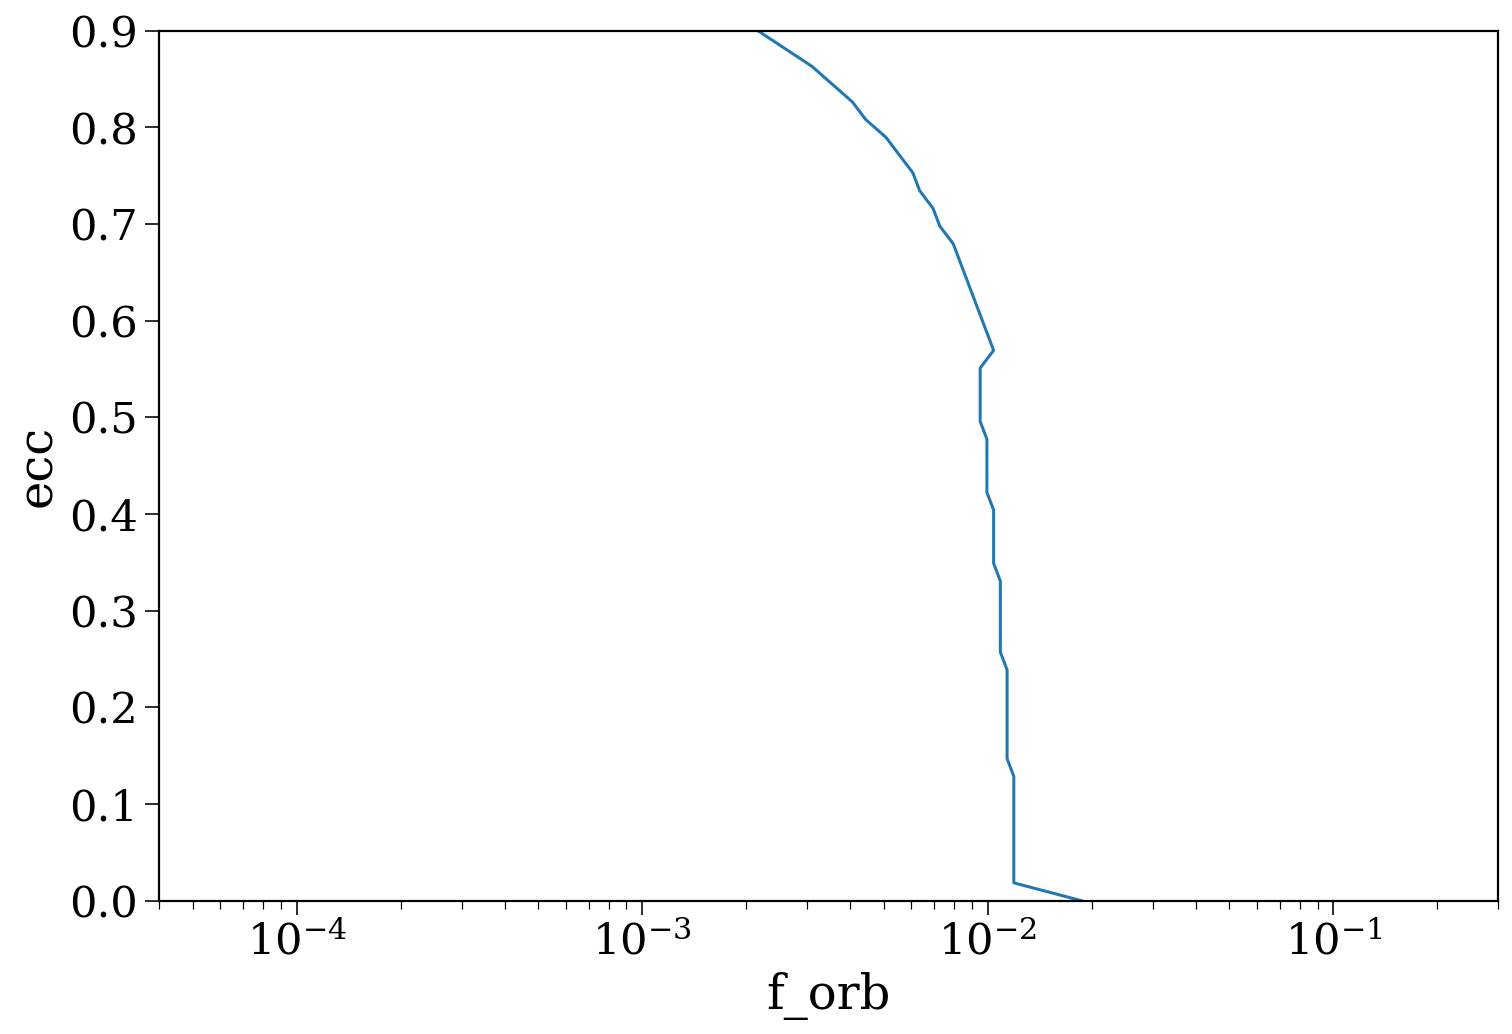

In [29]:
plt.plot(f_orb_grid[snr_grid.argmax(axis=0)], ecc_grid)
plt.xscale("log")
plt.xlim(4e-5, 3e-1)
plt.xlabel("f_orb")
plt.ylabel("ecc")
plt.ylim(0, 0.9)
plt.show()